In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform

In [2]:
vectors_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_labels.npy')
vectors_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_labels.npy')

In [3]:
def calculate_within_class_distances(feature_matrix, true_labels, metric):
    class_distances = {}
    unique_labels = np.unique(true_labels)

    for label in unique_labels:
        class_indices = np.where(true_labels == label)[0]
        class_features = feature_matrix[class_indices]
        distances = squareform(pdist(class_features, metric))
        class_distances[label] = distances

    return class_distances

def calculate_between_class_distances(feature_matrix, true_labels, metric):
    class_distances = {}
    unique_labels = np.unique(true_labels)

    for label in unique_labels:
        class_indices = np.where(true_labels == label)[0]
        other_indices = np.where(true_labels != label)[0]
        class_features = feature_matrix[class_indices]
        other_features = feature_matrix[other_indices]
        distances = cdist(class_features, other_features, metric)
        class_distances[label] = distances

    return class_distances

In [9]:
print(labels_baseline[:2])
test_distances_within_baseline = calculate_within_class_distances(vectors_baseline[:2], labels_baseline[:2], metric='euclidean')
print(test_distances_within_baseline)

[0 0]
{0: array([[0.        , 1.01932718],
       [1.01932718, 0.        ]])}


In [10]:
print(labels_embeddings[:2])
test_distances_between_embeddings = calculate_between_class_distances(vectors_embeddings[:2], labels_embeddings[:2], metric='euclidean')
print(test_distances_between_embeddings)

[11 18]
{11: array([[3.61261807]]), 18: array([[3.61261807]])}


In [12]:
print(labels_embeddings[:2])
test_distances_between_embeddings_cosine = calculate_between_class_distances(vectors_embeddings[:2], labels_embeddings[:2], metric='cosine')
print(test_distances_between_embeddings_cosine)
test_similarities_between_embeddings_cosine = {
        label: 1 - distances for label, distances in test_distances_between_embeddings_cosine.items()
    }
print(test_similarities_between_embeddings_cosine)
    

[11 18]
{11: array([[0.2227783]]), 18: array([[0.2227783]])}
{11: array([[0.7772217]]), 18: array([[0.7772217]])}


In [ ]:
within_class_file = "/home/ev357/rds/hpc-work/baseline_within.pkl"
between_class_file = "/home/ev357/rds/hpc-work/baseline_between.pkl"

with open(within_class_file, 'rb') as f:
    distances_within_baseline = pickle.load(f)
with open(between_class_file, 'rb') as f:
    distances_between_baseline = pickle.load(f)

In [ ]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_between.npy"

with open(within_class_file, 'rb') as f:
    distances_within_embeddings = pickle.load(f)
with open(between_class_file, 'rb') as f:
    distances_between_embeddings = pickle.load(f)

In [ ]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_between.npy"

with open(within_class_file, 'rb') as f:
    distances_within_embeddings_cosine = pickle.load(f)
with open(between_class_file, 'rb') as f:
    distances_between_embeddings_cosine = pickle.load(f)

In [ ]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_similarity_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_similarity_between.npy"

with open(within_class_file, 'rb') as f:
    similarity_within_embeddings_cosine = pickle.load(f)
with open(between_class_file, 'rb') as f:
    similarity_between_embeddings_cosine = pickle.load(f)

In [13]:
def plot_distance_histograms(class_distances_1, class_distances_2):
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))
    axes = axes.flatten()

    for i, ((label1, distances1), (label2, distances2)) in enumerate(zip(class_distances_1.items(), class_distances_2.items())):
        ax = axes[i]
        distances1 = distances1[np.triu_indices_from(distances1, k=1)]
        distances2 = distances2.flatten()
        
        ax.hist(distances1, bins=30, alpha=0.5, color='blue', label='Within class', density=True)
        ax.hist(distances2, bins=30, alpha=0.5, color='red', label='Between classes', density=True)
        
        ax.set_title(f'Class {label1}')
        ax.set_xlabel('Distance')
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()
    plt.show()

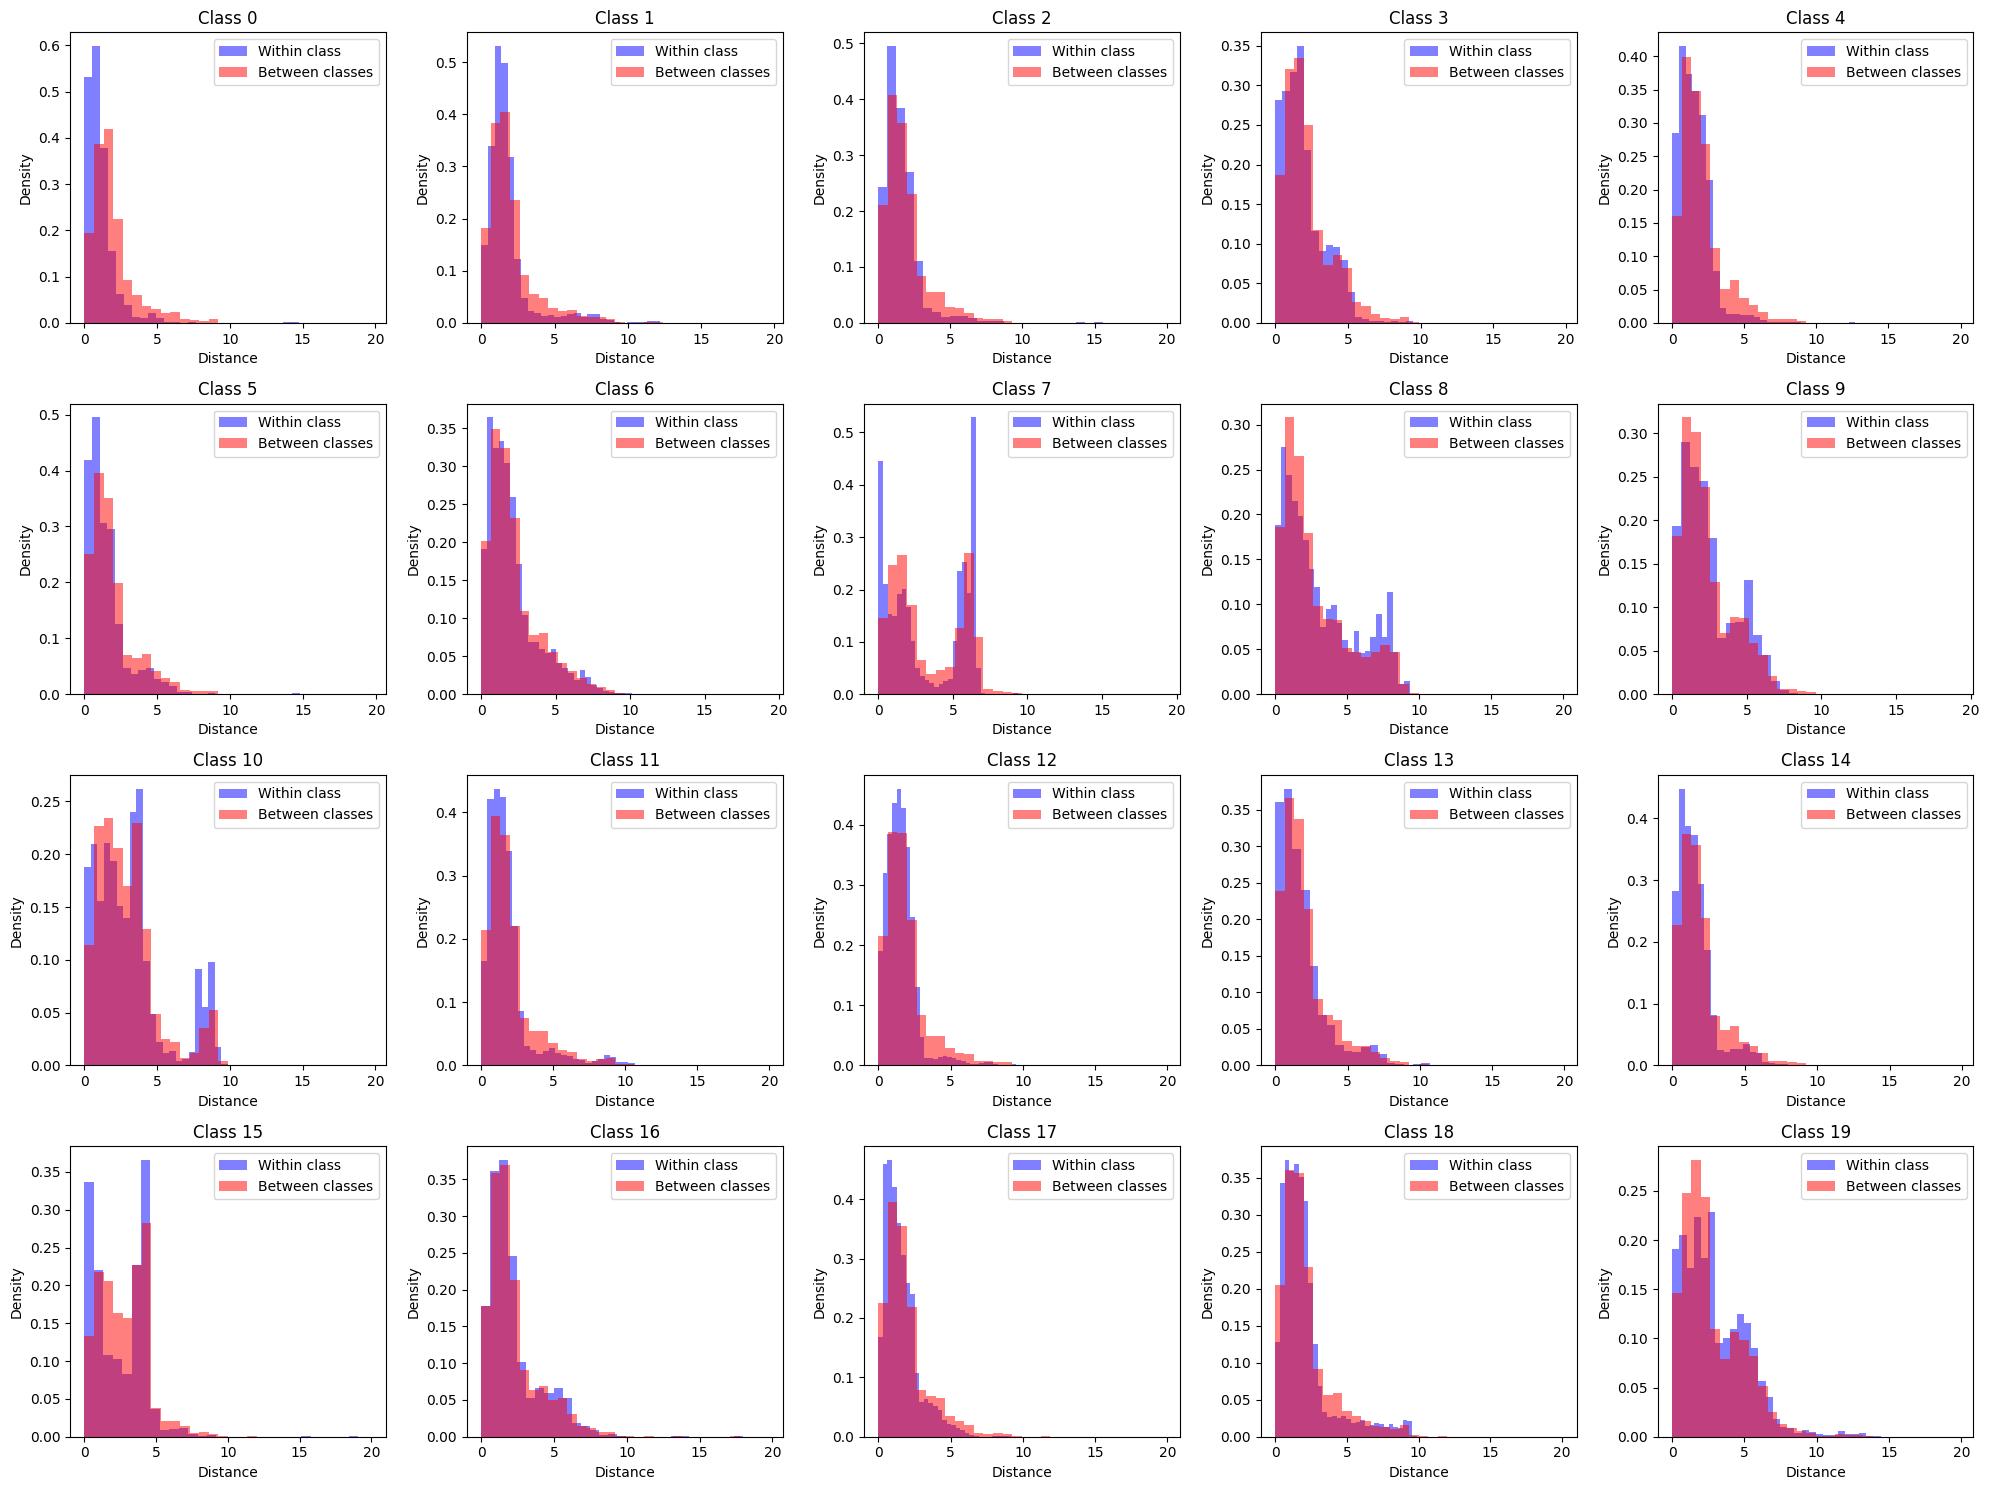

In [14]:
plot_distance_histograms(distances_within_baseline, distances_between_baseline)

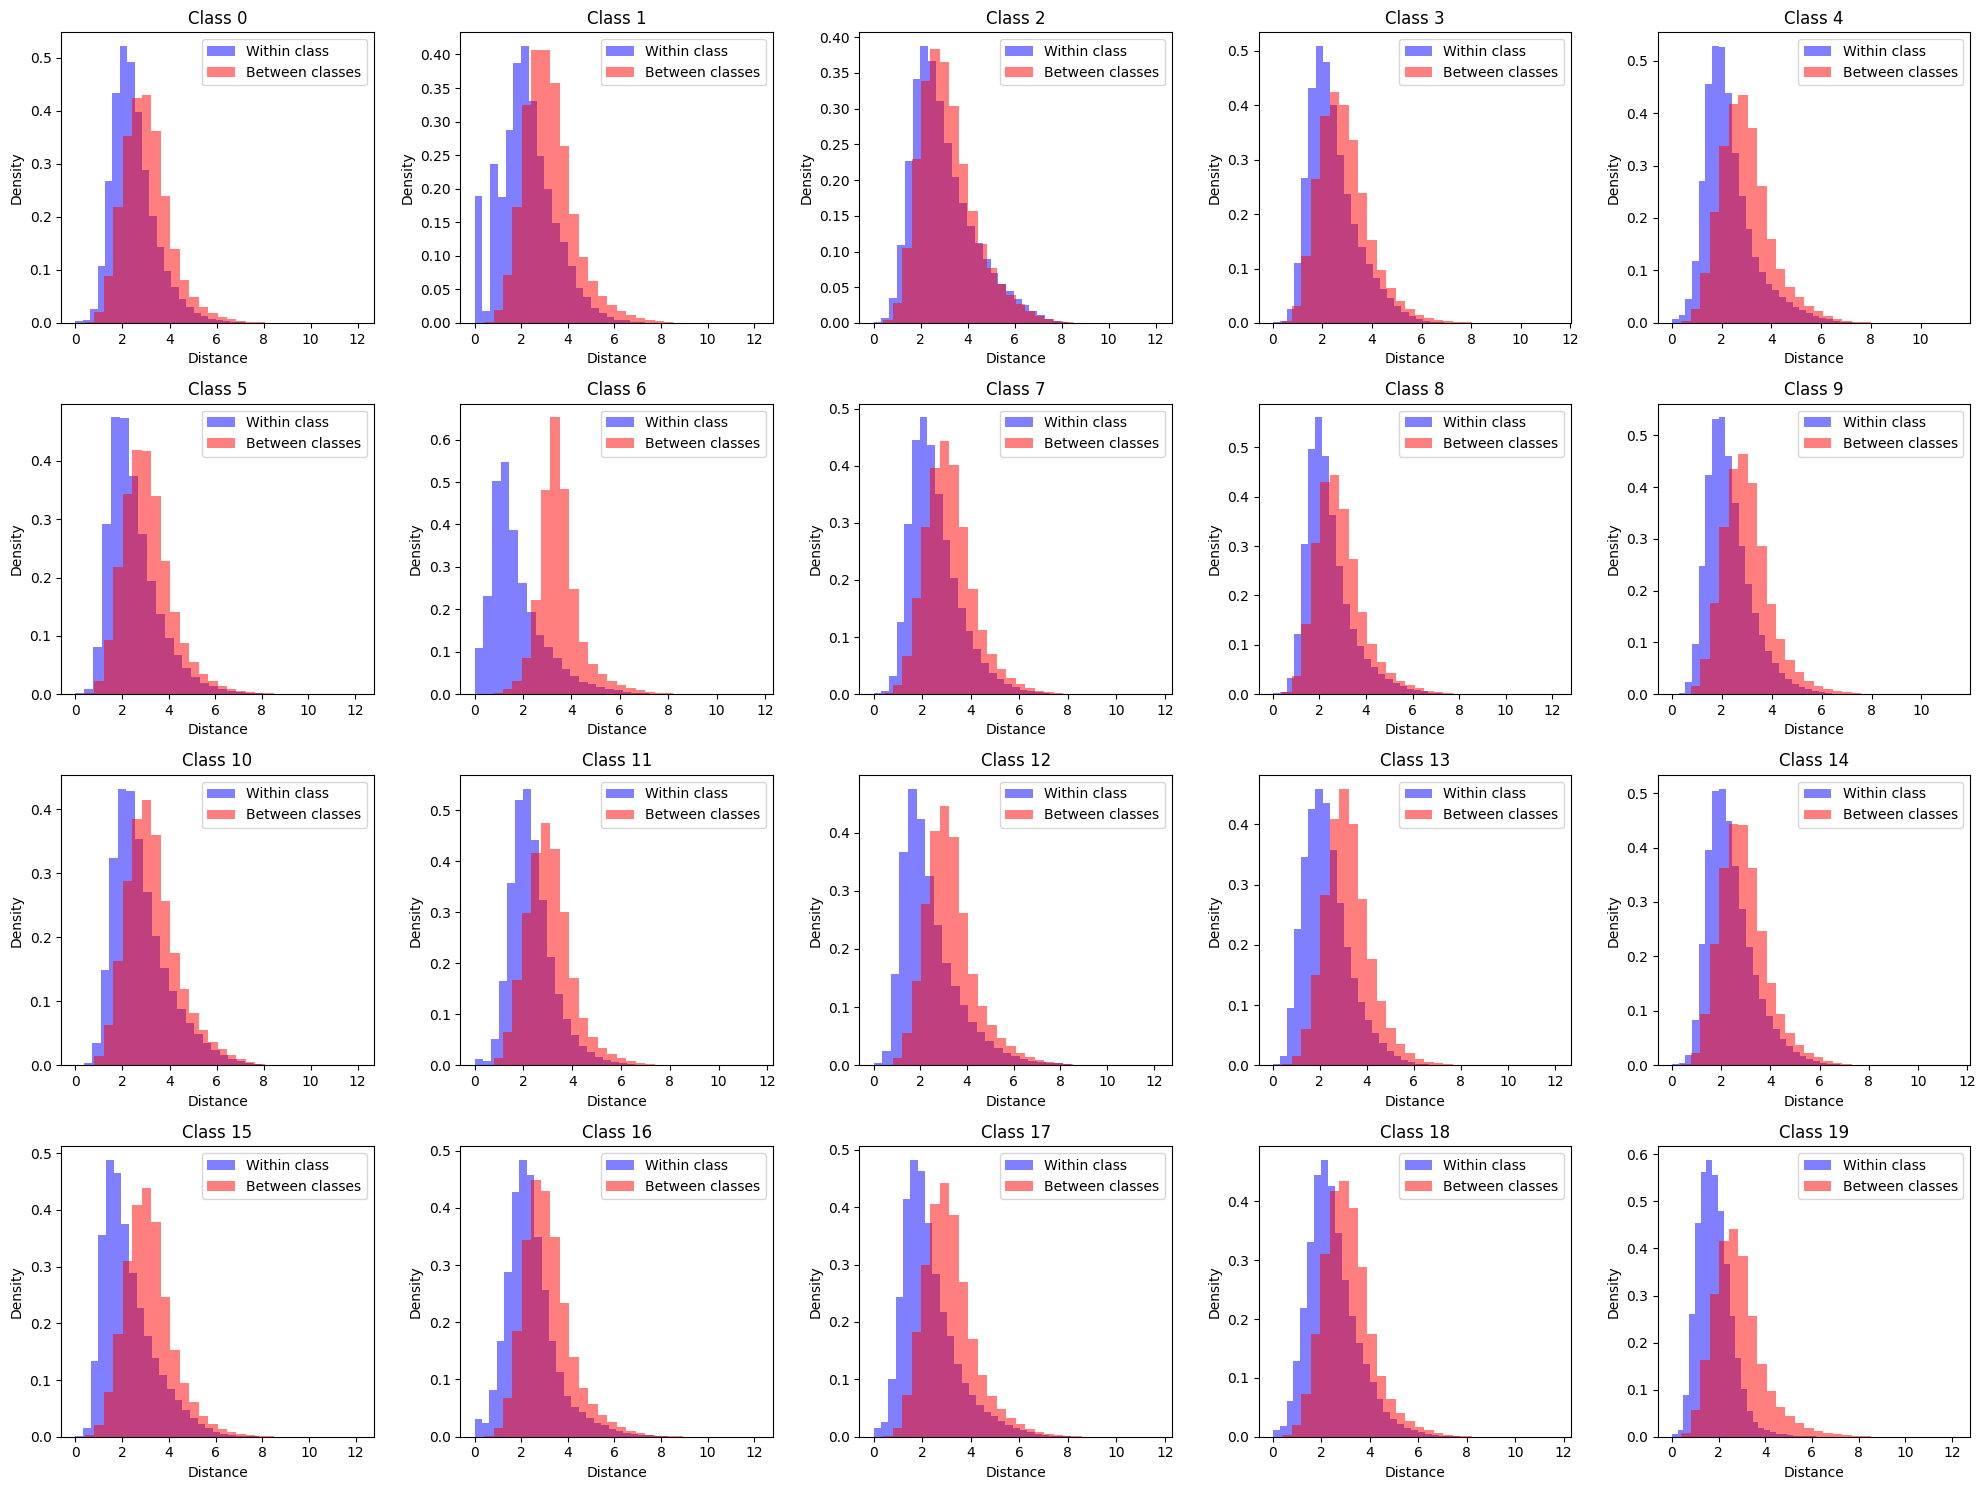

In [15]:
plot_distance_histograms(distances_within_embeddings, distances_between_embeddings)

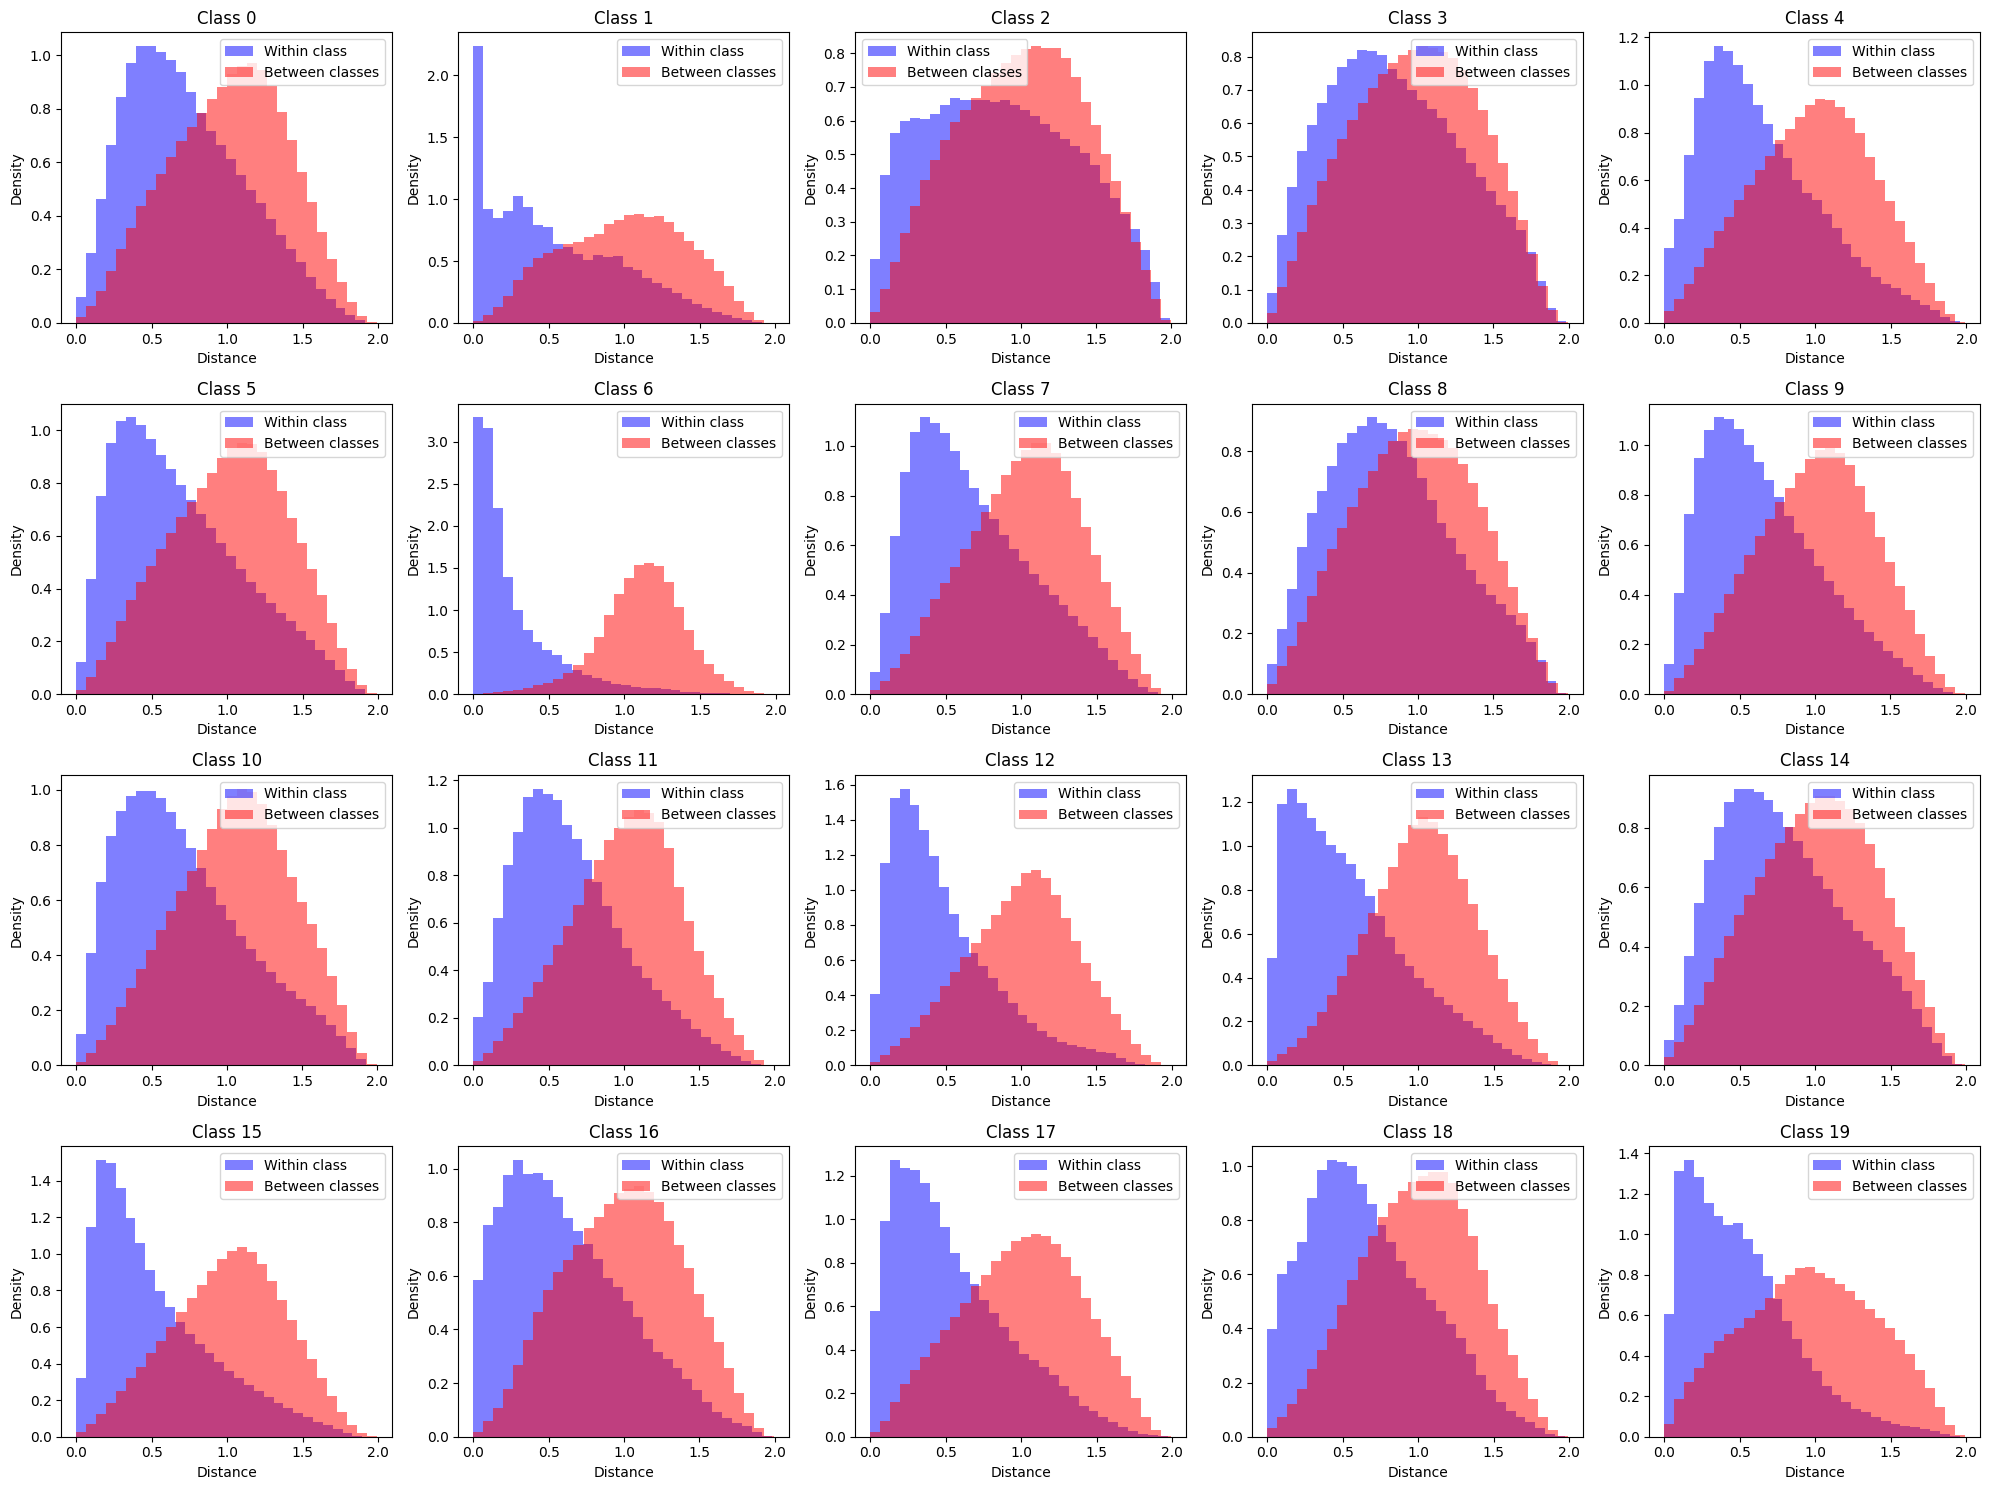

In [16]:
plot_distance_histograms(distances_within_embeddings_cosine, distances_between_embeddings_cosine)

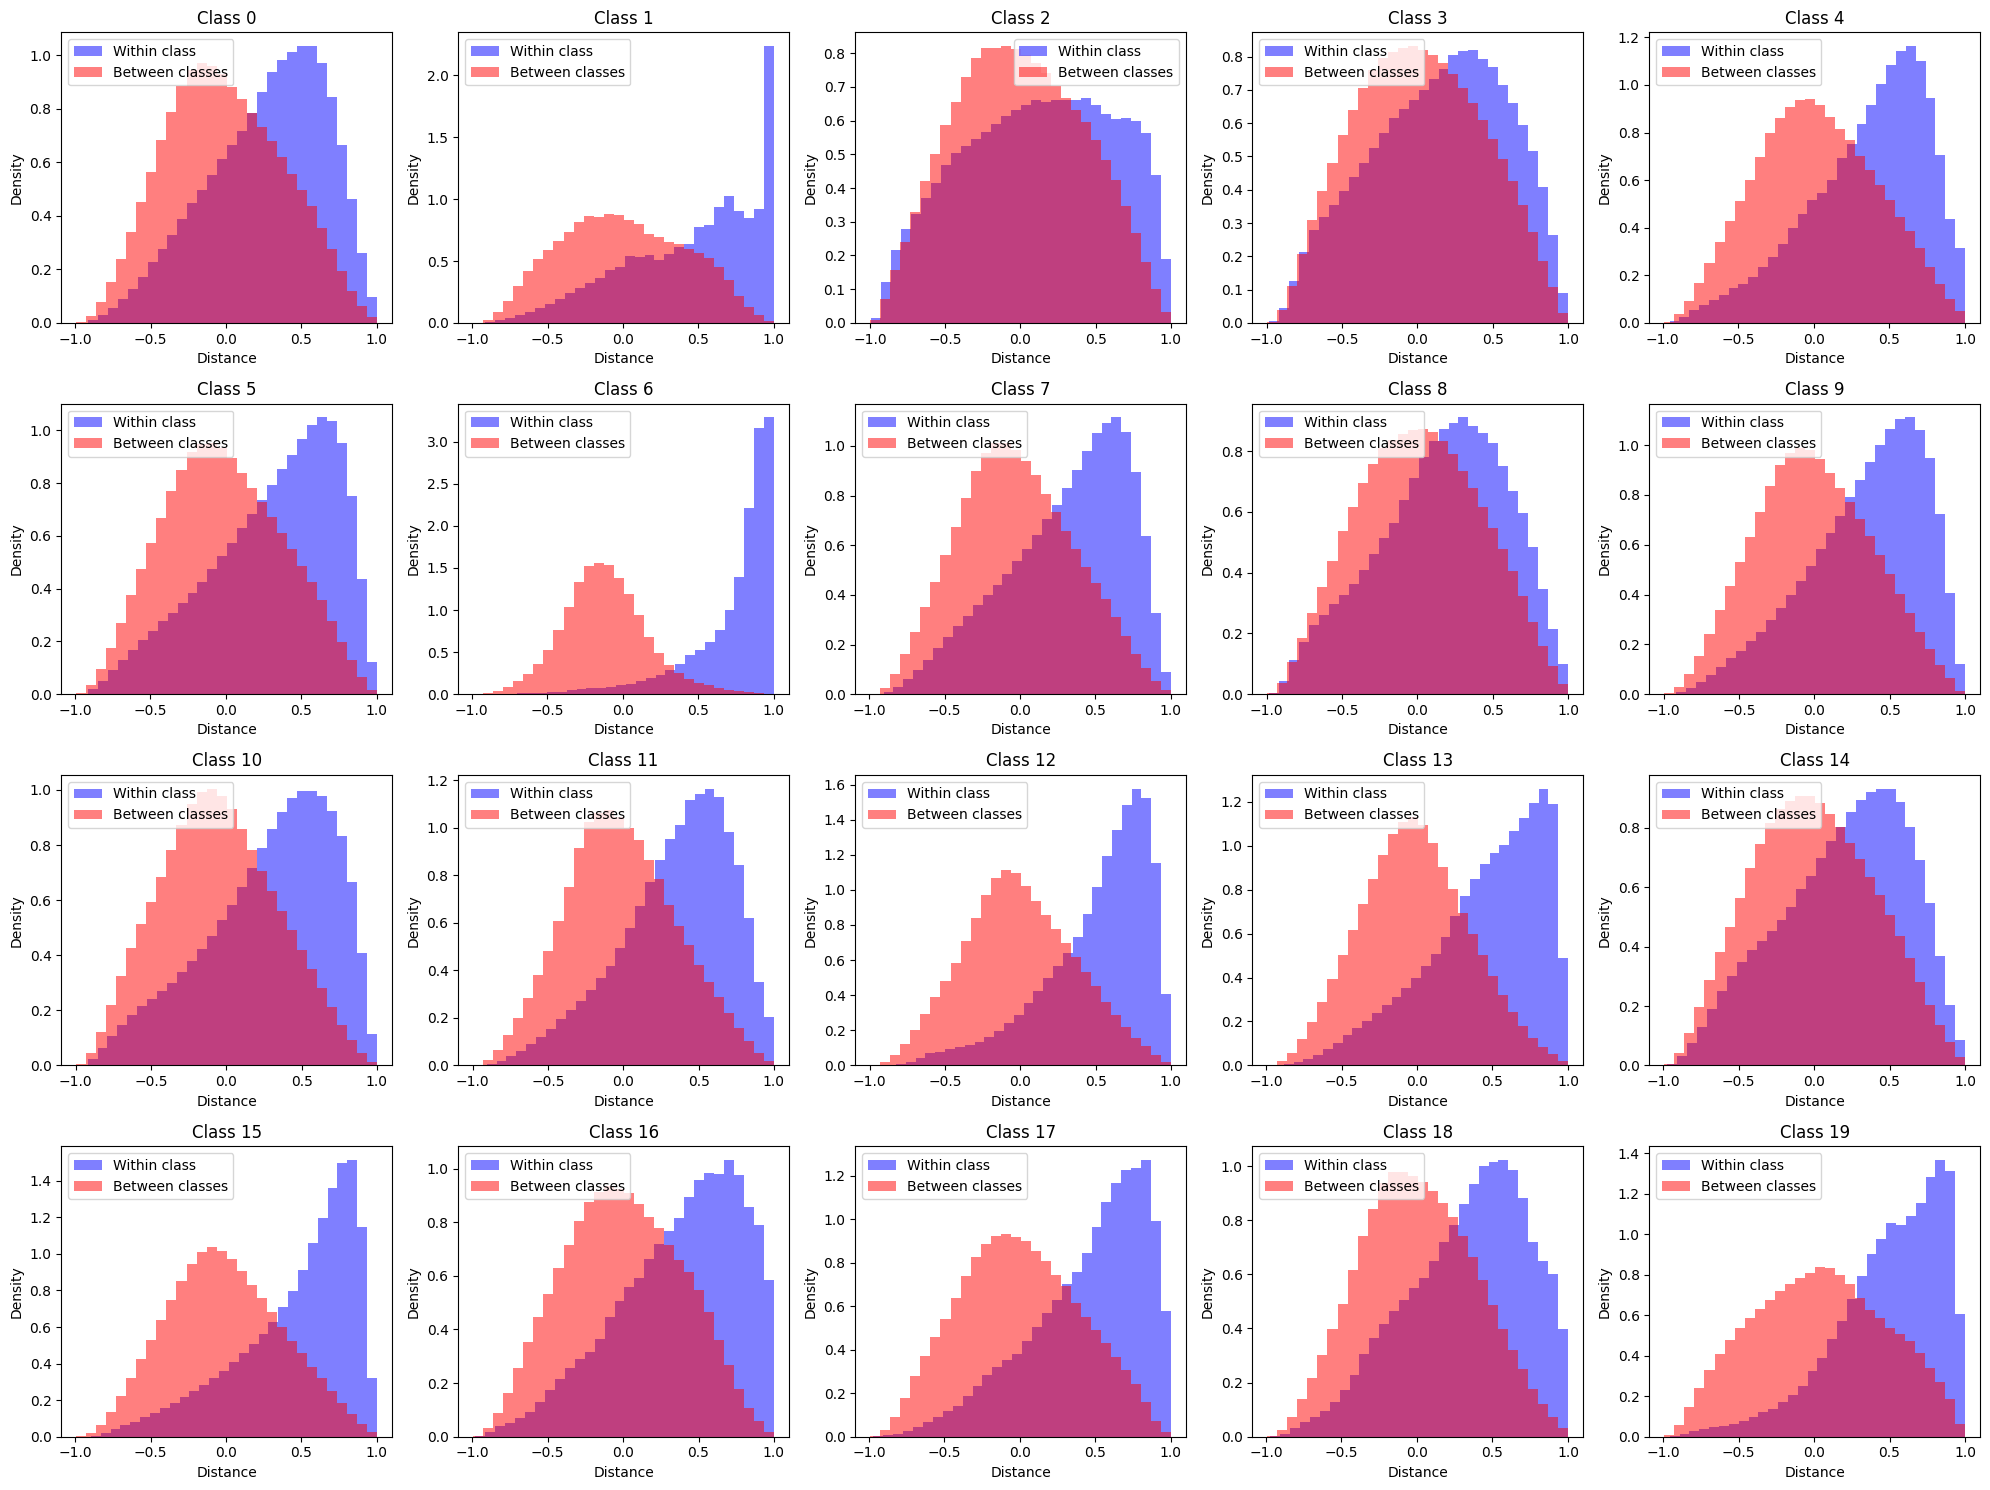

In [18]:
plot_distance_histograms(similarity_within_embeddings_cosine, similarity_between_embeddings_cosine)

In [19]:
def find_min_within(within_class_distances):
    min_distances = {}
    for label, distances in within_class_distances.items():
        np.fill_diagonal(distances, np.inf)
        min_distances[label] = np.min(distances, axis=1)
    return min_distances

def find_min_between(between_class_distances):
    min_distances = {}
    for label, distances in between_class_distances.items():
        min_distances[label] = np.min(distances, axis=1)
    return min_distances

def find_max_within(within_class_distances):
    max_distances = {}
    for label, distances in within_class_distances.items():
        distances = np.where(np.isinf(distances), np.nan, distances)
        np.fill_diagonal(distances, np.nan)
        max_distances[label] = np.nanmax(distances, axis=1)
    return max_distances

def find_max_between(between_class_distances):
    max_distances = {}
    for label, distances in between_class_distances.items():
        distances = np.where(np.isinf(distances), np.nan, distances)
        max_distances[label] = np.nanmax(distances, axis=1)
    return max_distances

In [20]:
min_within_baseline = find_min_within(distances_within_baseline)
min_between_baseline = find_min_between(distances_between_baseline)
min_within_embeddings = find_min_within(distances_within_embeddings)
min_between_embeddings = find_min_between(distances_between_embeddings)
min_within_embeddings_cosine = find_min_within(distances_within_embeddings_cosine)
min_between_embeddings_cosine = find_min_between(distances_between_embeddings_cosine)
max_within_embeddings_cosine_similarity = find_max_within(similarity_within_embeddings_cosine)
max_between_embeddings_cosine_similarity = find_max_between(similarity_between_embeddings_cosine)

In [23]:
def plot_min_histograms(min_within, min_between, xlim=1):
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))
    axes = axes.flatten()

    for i, (label, min_within_distances) in enumerate(min_within.items()):
        ax = axes[i]
        min_between_distances = min_between[label]
        
        ax.hist(min_within_distances, bins=30, alpha=0.5, color='blue', label='Min within', density=True)
        ax.hist(min_between_distances, bins=30, alpha=0.5, color='red', label='Min between', density=True)
        
        ax.set_title(f'Class {label}')
        ax.set_xlabel('Distance')
        ax.set_ylabel('Density')
        ax.set_xlim(0, xlim)
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_max_histograms(max_within, max_between, xlim=0):
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))
    axes = axes.flatten()

    for i, (label, max_within_distances) in enumerate(max_within.items()):
        ax = axes[i]
        max_between_distances = max_between[label]
        ax.hist(max_within_distances, bins=30, alpha=0.5, color='blue', label='Max within', density=True)
        ax.hist(max_between_distances, bins=30, alpha=0.5, color='red', label='Max between', density=True)
        
        ax.set_title(f'Class {label}')
        ax.set_xlabel('Distance')
        ax.set_ylabel('Density')
        ax.set_xlim(xlim, 1)
        ax.legend()

    plt.tight_layout()
    plt.show()

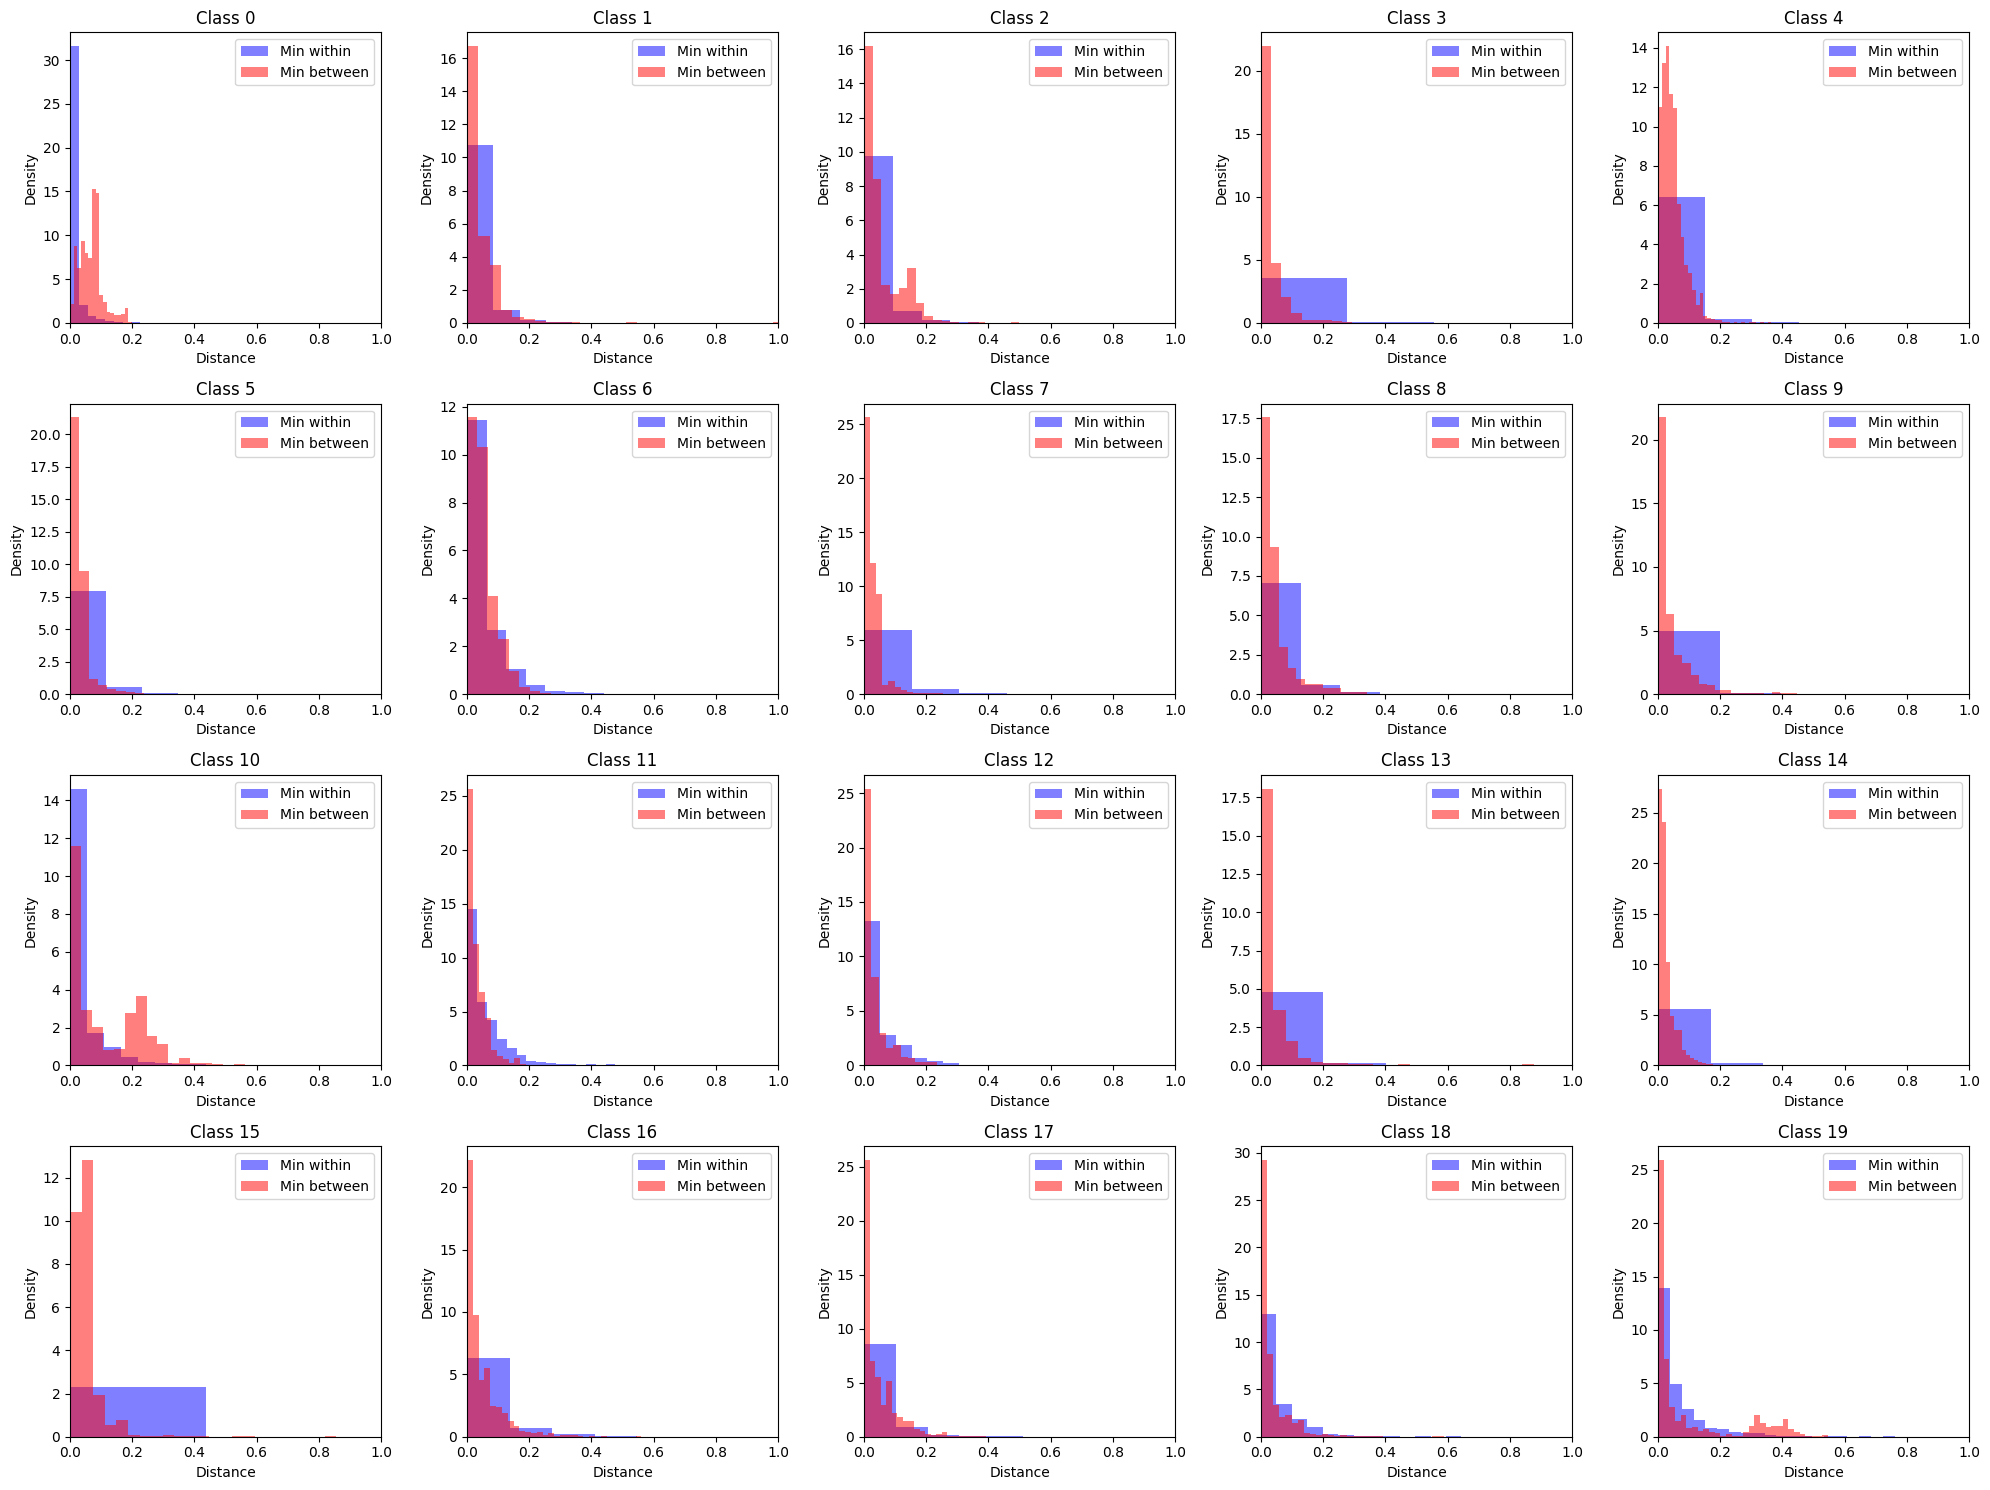

In [24]:
plot_min_histograms(min_within_baseline, min_between_baseline)

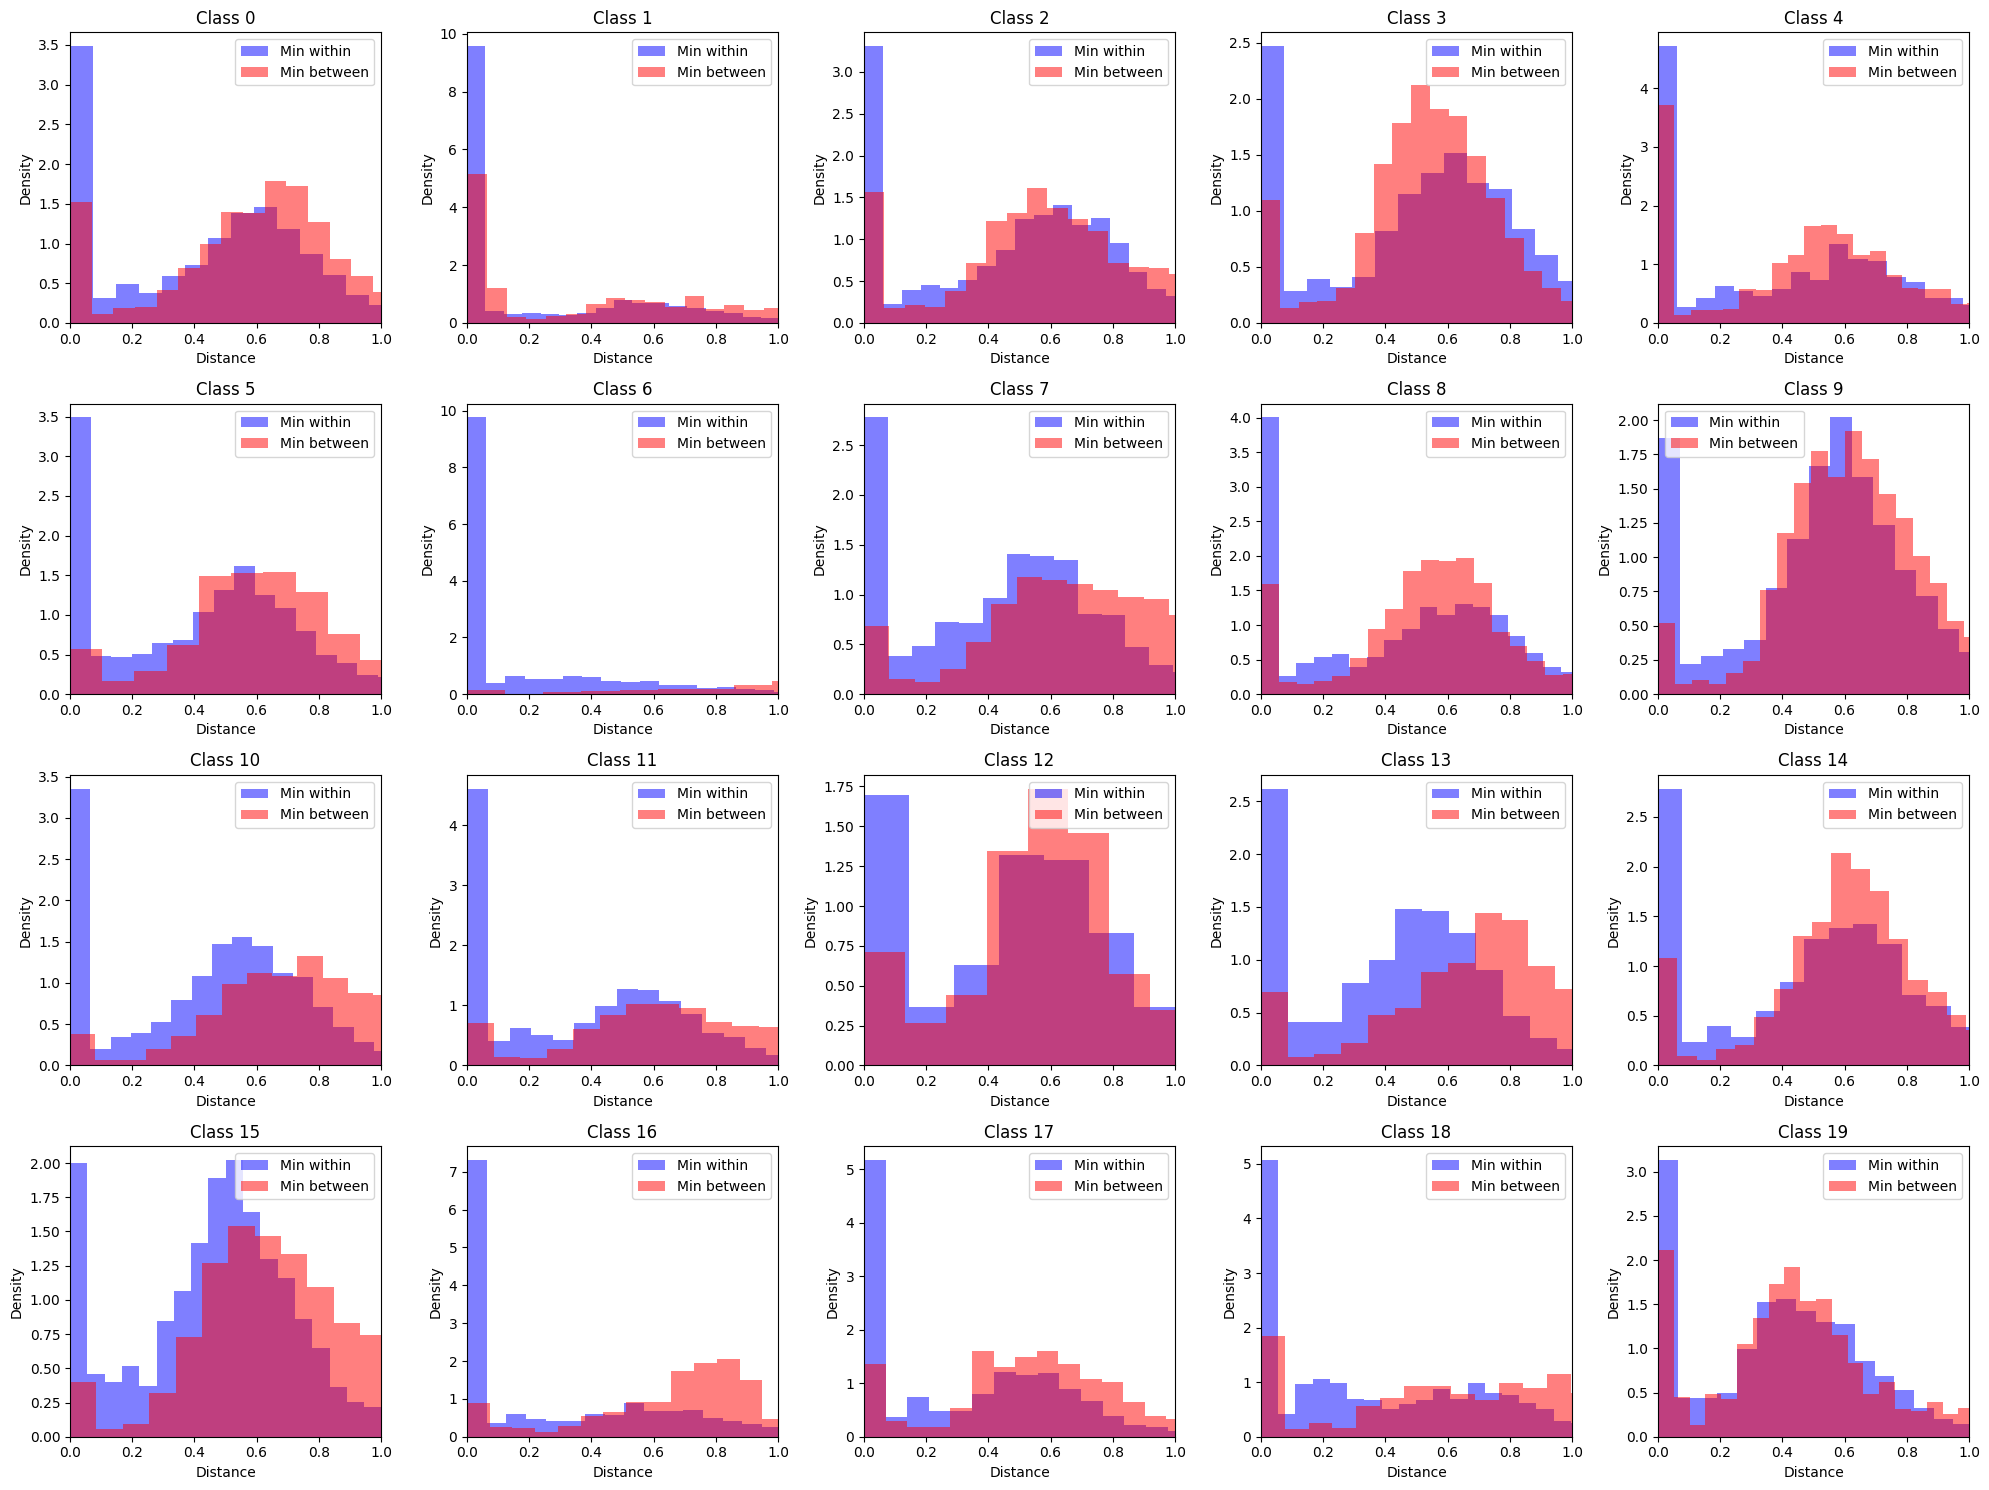

In [25]:
plot_min_histograms(min_within_embeddings, min_between_embeddings)

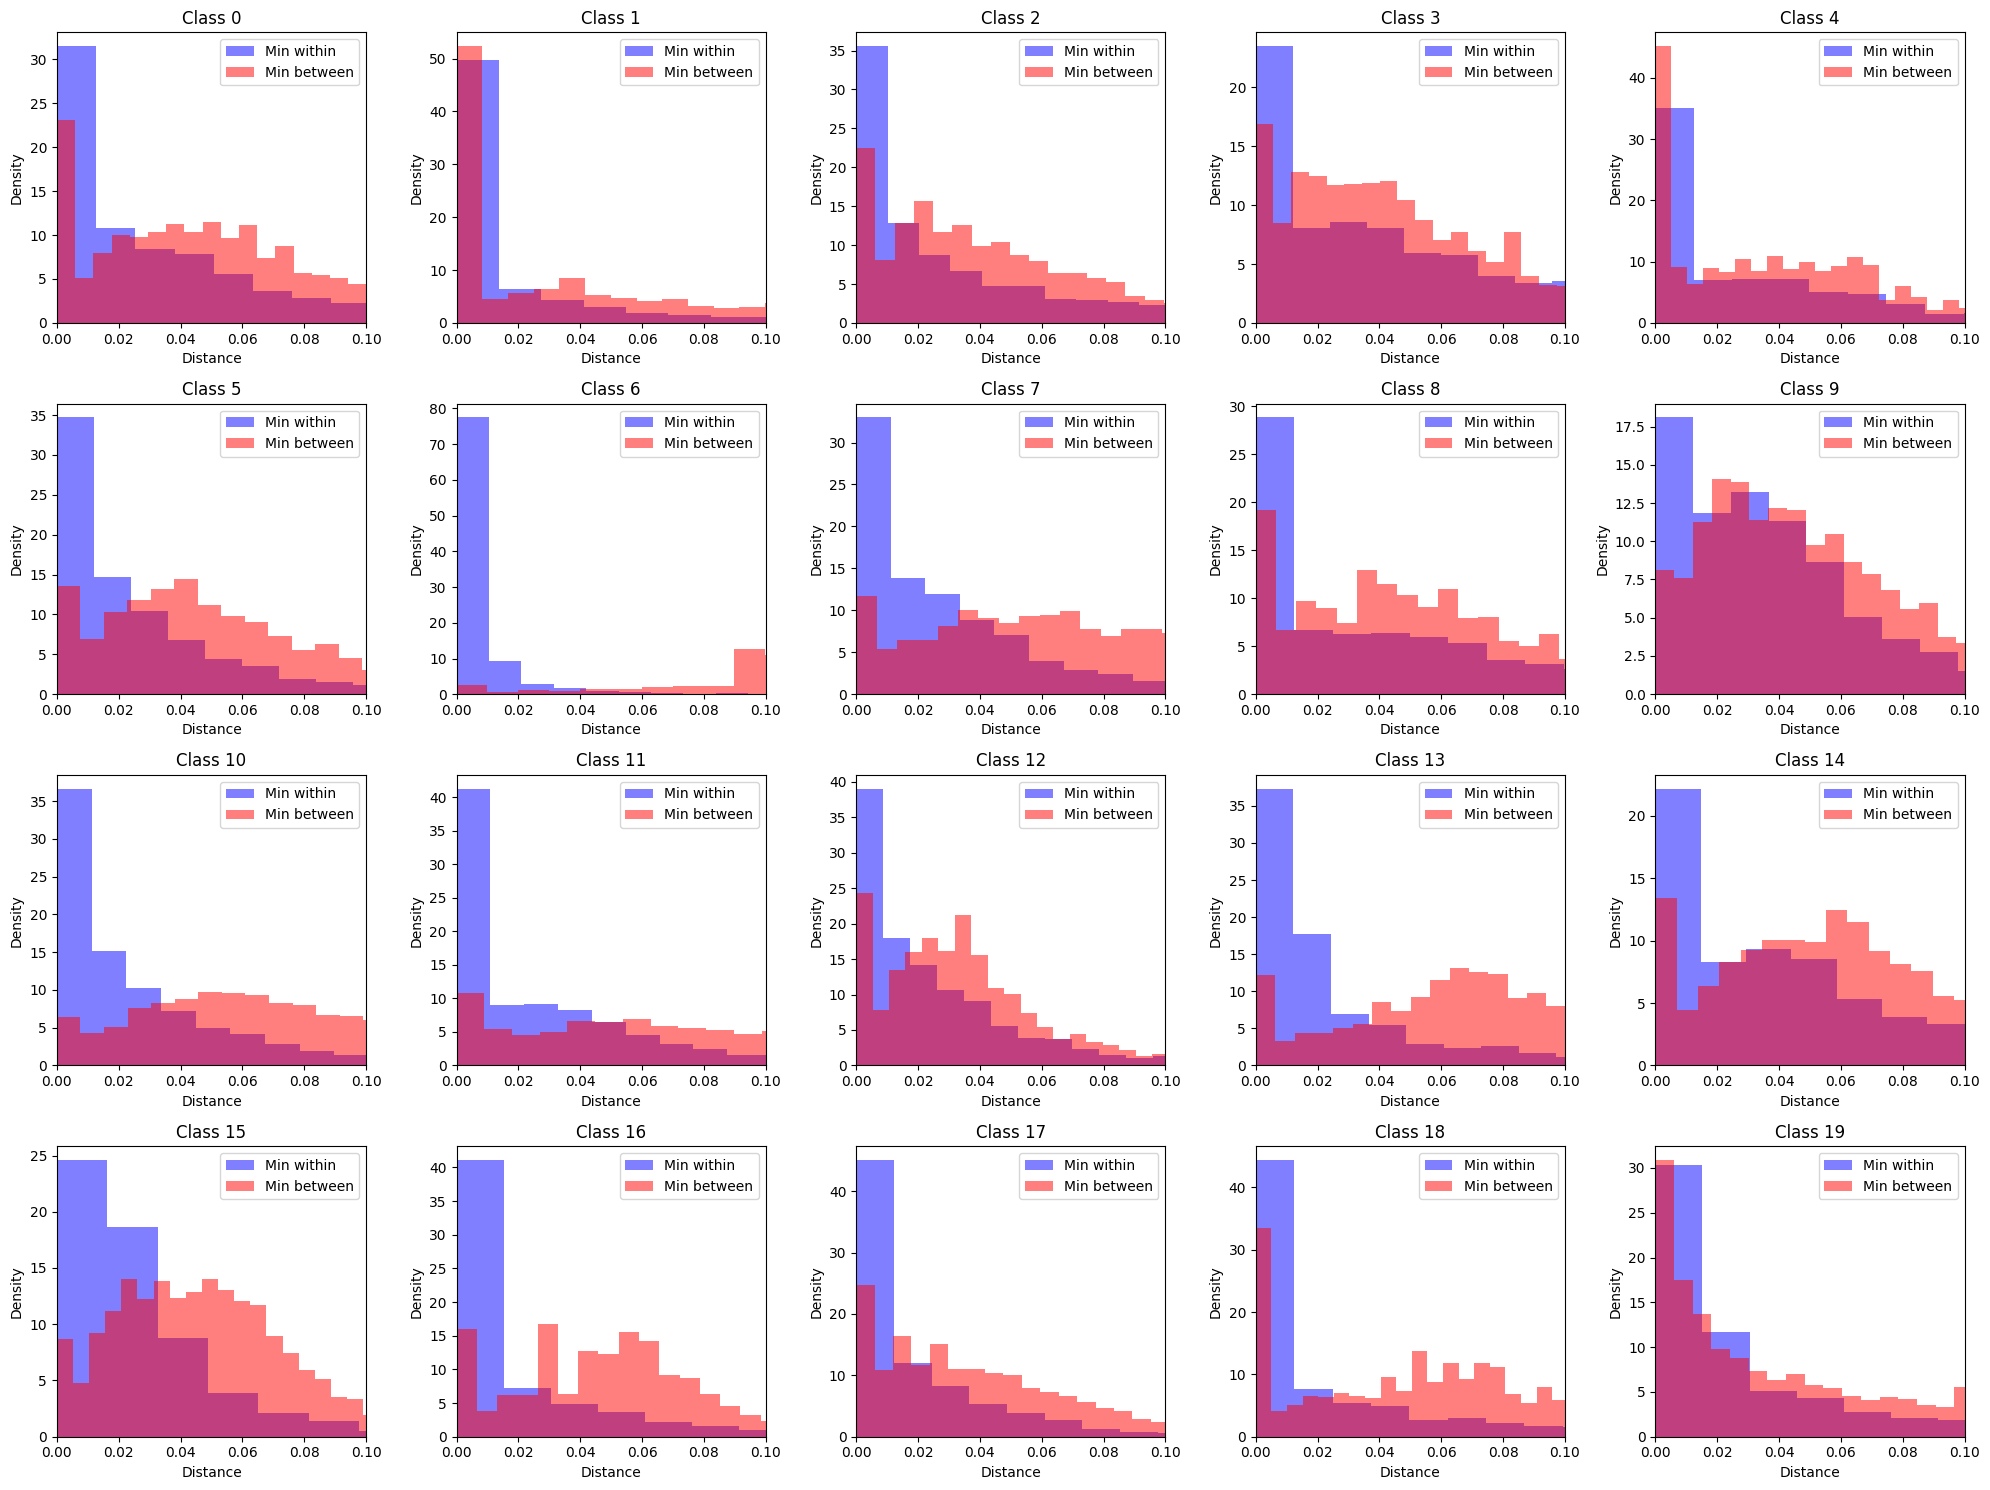

In [26]:
plot_min_histograms(min_within_embeddings_cosine, min_between_embeddings_cosine, xlim=0.1)

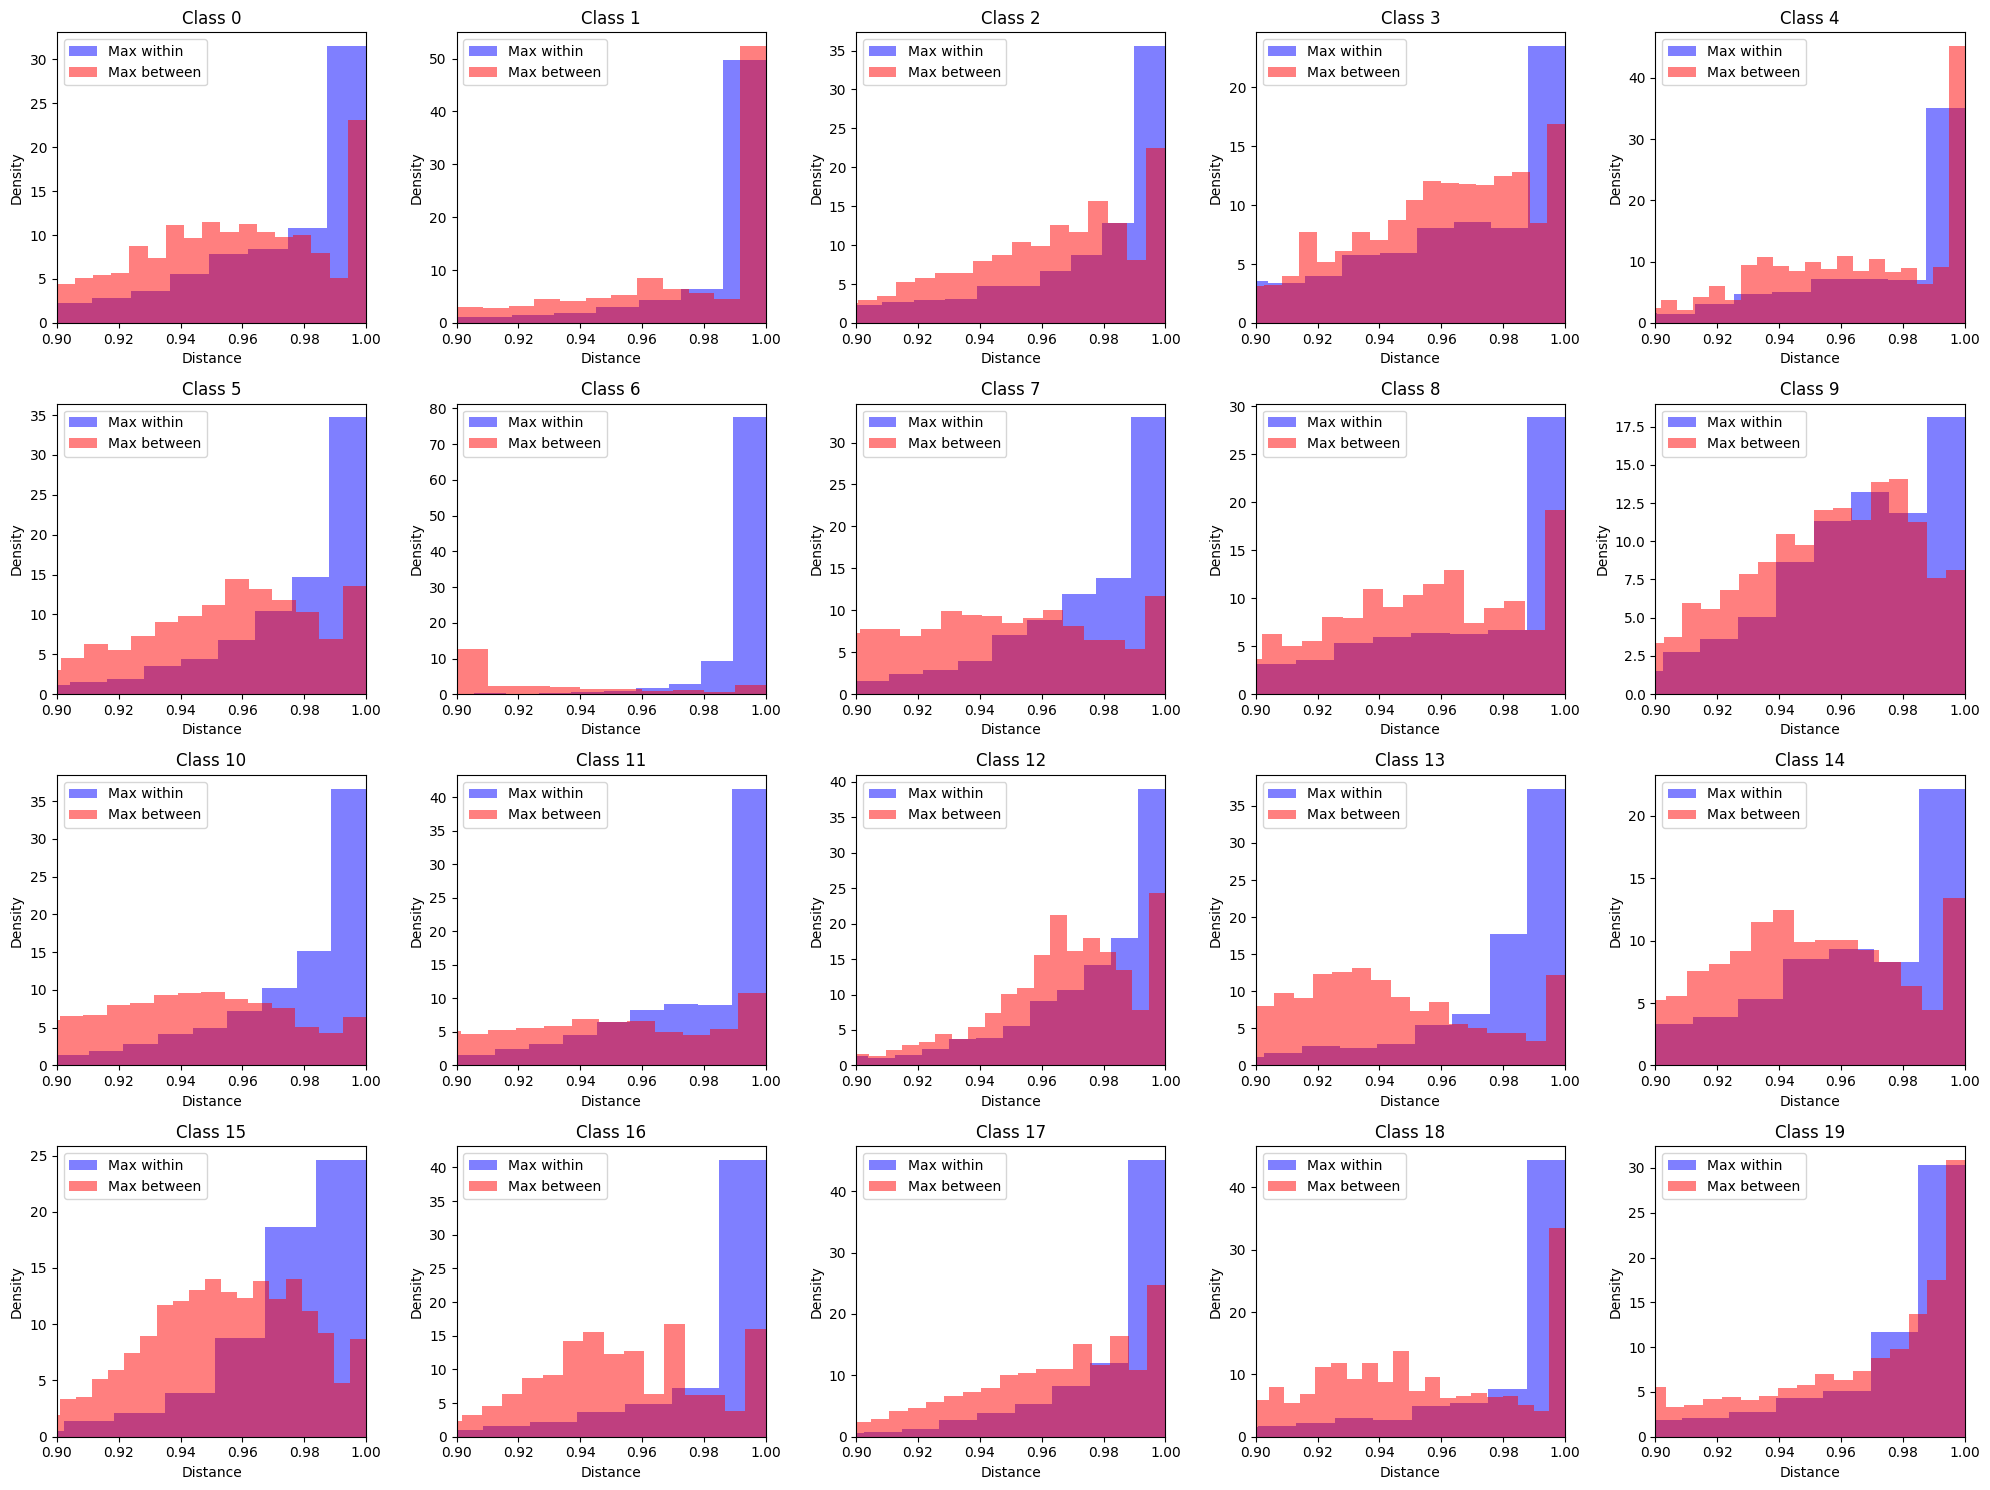

In [27]:
plot_max_histograms(max_within_embeddings_cosine_similarity, max_between_embeddings_cosine_similarity, xlim=0.9)

In [28]:
min_within_baseline_concatenated = np.concatenate(list(min_within_baseline.values()))
min_between_baseline_concatenated = np.concatenate(list(min_between_baseline.values()))
min_baseline_concatenated = np.minimum(min_within_baseline_concatenated, min_between_baseline_concatenated)

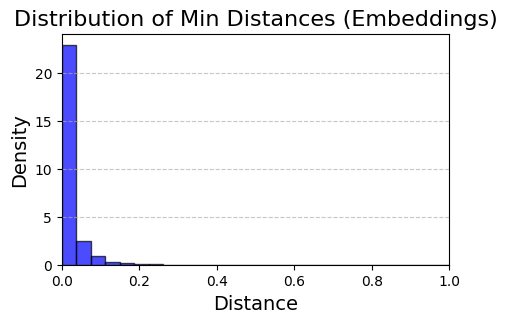

In [33]:
plt.figure(figsize=(5, 3))
plt.hist(min_baseline_concatenated, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Baseline)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
min_within_embeddings_concatenated = np.concatenate(list(min_within_embeddings.values()))
min_between_embeddings_concatenated = np.concatenate(list(min_between_embeddings.values()))
min_embeddings_concatenated = np.minimum(min_within_embeddings_concatenated, min_between_embeddings_concatenated)

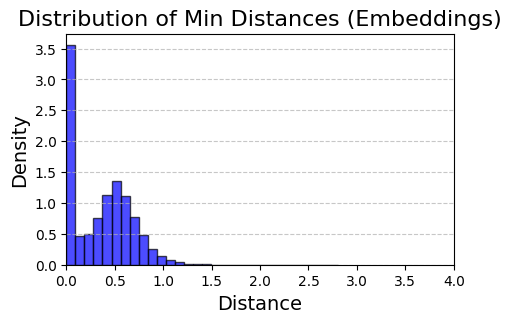

In [35]:
plt.figure(figsize=(5, 3))
plt.hist(min_embeddings_concatenated, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Embeddings)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
min_within_embeddings_cosine_concatenated = np.concatenate(list(min_within_embeddings_cosine.values()))
min_between_embeddings_cosine_concatenated = np.concatenate(list(min_between_embeddings_cosine.values()))
min_embeddings_cosine_concatenated = np.minimum(min_within_embeddings_cosine_concatenated, min_between_embeddings_cosine_concatenated)

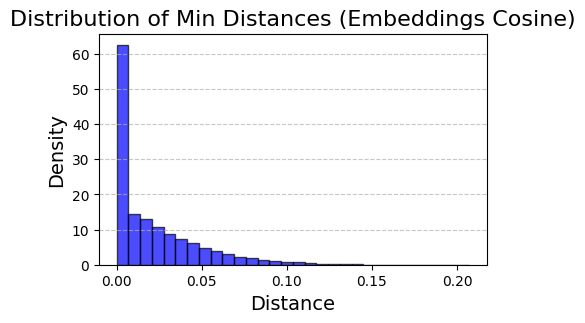

In [39]:
plt.figure(figsize=(5, 3))
plt.hist(min_embeddings_cosine_concatenated, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Embeddings Cosine)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
#plt.xlim(0, 4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()